# DiaGuide LLM Analysis

## Comparative Evaluation of Large Language Models and Healthcare Professionals in Diabetes Guidance

This notebook reproduces the results and figures from the study comparing GPT-4o (version 2024-08-06) responses with healthcare professional responses to diabetes-related questions.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from scipy.stats import chi2_contingency, mannwhitneyu, kruskal
import warnings
warnings.filterwarnings('ignore')

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12
})


## 1. Load the dataset


In [2]:
df = pd.read_csv('ratings_v310125.csv')
print(f"Dataset shape: {df.shape}")

# Display basic information about the dataset
df.info()


Dataset shape: (1810, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1810 entries, 0 to 1809
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            1810 non-null   int64  
 1   session_id                    1810 non-null   float64
 2   answer_id                     1810 non-null   int64  
 3   question_id                   1810 non-null   int64  
 4   knowledge                     1810 non-null   int64  
 5   helpfulness                   1810 non-null   int64  
 6   empathy                       1810 non-null   int64  
 7   response_time                 1810 non-null   int64  
 8   created_at                    1810 non-null   object 
 9   user_id                       1810 non-null   int64  
 10  age_group                     1810 non-null   object 
 11  gender                        1810 non-null   object 
 12  has_diabetes                  1810 n

## 2. Data Preprocessing and Cleaning


In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])

# Convert columns to appropriate types if needed
# Convert binary columns to boolean
df['is_healthcare_personnel'] = df['is_healthcare_personnel'].astype(bool)
df['previous_participation'] = df['previous_participation'].astype(bool)

# Display basic statistics
print("\nBasic statistics:")
df.describe()



Missing values per column:
healthcare_professional_type    1287
end_time                         357
dtype: int64

Basic statistics:


,id,session_id,answer_id,question_id,knowledge,helpfulness,empathy,response_time,user_id
count,1810.000000,1810.000000,1810.000000,1810.000000,1810.000000,1810.000000,1810.000000,1.810000e+03,1810.000000
mean,910.186740,211.045304,116.976796,58.742541,3.785635,3.702762,3.576796,6.958876e+04,211.045304
std,527.364021,116.756569,66.261643,33.122201,1.019117,1.020543,1.071730,3.216181e+05,116.756569
min,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.106000e+03,2.000000
25%,453.250000,114.000000,61.000000,31.000000,3.000000,3.000000,3.000000,2.491225e+04,114.000000
50%,910.500000,212.000000,132.000000,66.000000,4.000000,4.000000,4.000000,4.044350e+04,212.000000
75%,1366.750000,302.000000,174.000000,87.000000,5.000000,4.000000,4.000000,6.463175e+04,302.000000
max,1855.000000,451.000000,228.000000,114.000000,5.000000,5.000000,5.000000,7.953561e+06,451.000000


## 3. Exploratory Data Analysis

### 3.1 Dataset Overview


In [4]:
# --- 1. Total ratings and breakdown by source ---
total_ratings = len(df)
llm_ratings = (df['source'].str.lower() == 'llm').sum()
human_ratings = (df['source'].str.lower() == 'human').sum()

print(f"A total of {total_ratings} response ratings were collected, comprising {llm_ratings} evaluations of GPT-4o responses and {human_ratings} evaluations of responses from healthcare professionals.")

A total of 1810 response ratings were collected, comprising 890 evaluations of GPT-4o responses and 920 evaluations of responses from healthcare professionals.


In [5]:
# --- 2. Unique participants, questions, and answers ---
n_participants = df['user_id'].nunique()
n_questions = df['question_id'].nunique()
n_answers = df['answer_id'].nunique()

print(f"In total, {n_participants} participants took part in the study, evaluating {n_questions} unique questions and {n_answers} corresponding answers.")


In total, 273 participants took part in the study, evaluating 113 unique questions and 203 corresponding answers.


In [6]:
# --- 3. Number of LLM and human answers (not ratings) ---
n_llm_answers = df[df['source'].str.lower() == 'llm']['answer_id'].nunique()
n_human_answers = df[df['source'].str.lower() == 'human']['answer_id'].nunique()
print(f"(LLM: n = {n_llm_answers} human: n = {n_human_answers})")


(LLM: n = 103 human: n = 100)


In [7]:
# --- 4. Ratings per participant ---
ratings_per_user = df.groupby('user_id').size()
mean_ratings_per_user = ratings_per_user.mean()
sd_ratings_per_user = ratings_per_user.std()
median_ratings_per_user = ratings_per_user.median()

print(f"On average, each participant contributed {mean_ratings_per_user:.1f} ratings (SD = {sd_ratings_per_user:.2f}), with a median of {median_ratings_per_user} ratings.")

On average, each participant contributed 6.6 ratings (SD = 3.96), with a median of 10.0 ratings.


In [8]:
# --- 5. Ratings per question ---
ratings_per_question = df.groupby('question_id').size()
mean_ratings_per_question = ratings_per_question.mean()
sd_ratings_per_question = ratings_per_question.std()

print(f"The mean number of ratings per question was {mean_ratings_per_question:.2f} (SD = {sd_ratings_per_question:.2f}).")

The mean number of ratings per question was 16.02 (SD = 12.57).


In [9]:
# --- 6. Participants who completed the survey more than once ---
n_repeat_participants = df.groupby('user_id')['session_id'].nunique().gt(1).sum()
percent_repeat = 100 * n_repeat_participants / n_participants

print(f"{n_repeat_participants} participants ({percent_repeat:.1f}%) completed the survey more than once.")

# We write errouneously: "Two participants (0.7 %) completed the survey more than once."

0 participants (0.0%) completed the survey more than once.


In [10]:
# --- 7. Question lengths ---

# Get the first question text for each question_id
questions = df.groupby('question_id')['question_text'].first()

# Character counts
char_lengths = questions.str.len()

# Word counts
word_lengths = questions.str.split().apply(len)

# Character statistics
mean_char = char_lengths.mean()
sd_char = char_lengths.std()
median_char = char_lengths.median()
min_char = char_lengths.min()
max_char = char_lengths.max()

# Word statistics
mean_word = word_lengths.mean()
sd_word = word_lengths.std()
median_word = word_lengths.median()
min_word = word_lengths.min()
max_word = word_lengths.max()

print(f"Question lengths (characters): {min_char}–{max_char}, mean = {mean_char:.1f} (SD = {sd_char:.1f}), median = {median_char}")
print(f"Question lengths (words): {min_word}–{max_word}, mean = {mean_word:.1f} (SD = {sd_word:.1f}), median = {median_word}")


Question lengths (characters): 19–1091, mean = 265.8 (SD = 244.0), median = 185.0
Question lengths (words): 3–199, mean = 46.7 (SD = 43.8), median = 35.0


Descriptive statistics for the length of answers (in both characters and words), 
separately for GPT-4o (LLM) and Human answers

In [11]:
# --- 8. Length of answers ---
# Ensure source column is lowercase for consistency
df['source'] = df['source'].str.lower()

# Get the first answer text for each answer_id and source
answers = df.groupby(['answer_id', 'source'])['answer_text'].first().reset_index()

for src in ['llm', 'human']:
    ans_src = answers[answers['source'] == src]['answer_text']
    char_lengths = ans_src.str.len()
    word_lengths = ans_src.str.split().apply(len)
    
    print(f"\n{src.upper()} ANSWERS:")
    print(f"Characters: min={char_lengths.min()}, max={char_lengths.max()}, mean={char_lengths.mean():.1f} (SD={char_lengths.std():.1f}), median={char_lengths.median()}")
    print(f"Words: min={word_lengths.min()}, max={word_lengths.max()}, mean={word_lengths.mean():.1f} (SD={word_lengths.std():.1f}), median={word_lengths.median()}")


LLM ANSWERS:
Characters: min=231, max=2129, mean=798.2 (SD=456.6), median=632.0
Words: min=36, max=331, mean=121.6 (SD=69.8), median=96.0

HUMAN ANSWERS:
Characters: min=126, max=1770, mean=694.5 (SD=398.8), median=588.0
Words: min=19, max=286, mean=114.9 (SD=65.2), median=101.0


In [12]:
repeat_users = df.groupby('user_id')['session_id'].nunique()
print(repeat_users[repeat_users > 1])

Series([], Name: session_id, dtype: int64)


### 3.2 Participant Demographics


In [13]:
def generate_demographic_table():
    # Participant groups
    groups = {
        'Diabetes and Healthcare Professional': df[(df['has_diabetes'] == 'yes') & 
                                                 (df['is_healthcare_personnel'] == True)],
        'Only Diabetes': df[(df['has_diabetes'] == 'yes') & 
                           (df['is_healthcare_personnel'] == False)],
        'Only Healthcare Professional': df[(df['has_diabetes'] == 'no') & 
                                         (df['is_healthcare_personnel'] == True)],
        'Neither': df[(df['has_diabetes'] == 'no') & 
                     (df['is_healthcare_personnel'] == False)]
    }
    
    demographic_data = []
    
    # Count unique users in each group
    for group_name, group_df in groups.items():
        unique_users = group_df['user_id'].nunique()
        ratings_count = group_df.shape[0]
        demographic_data.append({
            'Characteristic': 'Participant and Groups',
            'Subgroup': group_name,
            'Frequency (N)': unique_users,
            'Ratings': ratings_count
        })
    
    # Age groups
    age_groups = df.groupby('age_group')
    for age, group in age_groups:
        demographic_data.append({
            'Characteristic': 'Age Group',
            'Subgroup': age,
            'Frequency (N)': group['user_id'].nunique(),
            'Ratings': group.shape[0]
        })
        
    # Gender
    gender_groups = df.groupby('gender')
    for gender, group in gender_groups:
        demographic_data.append({
            'Characteristic': 'Gender',
            'Subgroup': gender,
            'Frequency (N)': group['user_id'].nunique(),
            'Ratings': group.shape[0]
        })
        
    # Education Level
    edu_groups = df.groupby('education_level')
    for edu, group in edu_groups:
        demographic_data.append({
            'Characteristic': 'Education Level',
            'Subgroup': edu,
            'Frequency (N)': group['user_id'].nunique(),
            'Ratings': group.shape[0]
        })
        
    # Healthcare Professional Type
    hcp_groups = df[df['is_healthcare_personnel']].groupby('healthcare_professional_type')
    for hcp_type, group in hcp_groups:
        if pd.notna(hcp_type):  # Skip NaN values
            demographic_data.append({
                'Characteristic': 'Healthcare Professional Type',
                'Subgroup': hcp_type,
                'Frequency (N)': group['user_id'].nunique(),
                'Ratings': group.shape[0]
            })
    
    # Create a DataFrame for better display
    demographic_table = pd.DataFrame(demographic_data)
    
    return demographic_table

# Generate and display the demographic table
demographic_table = generate_demographic_table()
demographic_table


,Characteristic,Subgroup,Frequency (N),Ratings
0,Participant and Groups,Diabetes and Healthcare Professional,48,322
1,Participant and Groups,Only Diabetes,175,1181
2,Participant and Groups,Only Healthcare Professional,33,211
3,Participant and Groups,Neither,17,96
4,Age Group,0-19,4,14
5,Age Group,20-29,41,238
6,Age Group,30-39,44,264
7,Age Group,40-49,74,539
8,Age Group,50-59,70,510
9,Age Group,60+,40,245


#### Table 1

In [14]:
# Deduplicate to unique participants
df_unique = df.drop_duplicates('user_id')

N = len(df_unique)

# --- Age groups ---
age_order = ['0-19', '20-29','30-39', '40-49', '50-59', '60+']
age_counts = df_unique['age_group'].value_counts().reindex(age_order, fill_value=0)
age_perc = 100 * age_counts / N

# --- Gender ---
gender_map = {
    'female': 'Female',
    'male': 'Male',
    'prefer_not_to_say': 'Not disclosed'
}
gender_order = ['female', 'male', 'prefer_not_to_say']
gender_counts = df_unique['gender'].value_counts().reindex(gender_order, fill_value=0)
gender_perc = 100 * gender_counts / N

# --- Clinical Status ---
def clinical_status(row):
    if row['is_healthcare_personnel']:
        if row['has_diabetes'].lower() == 'yes':
            return 'Healthcare professionals with diabetes'
        else:
            return 'Healthcare professionals (non-diabetic)'
    elif row['has_diabetes'].lower() == 'yes':
        return 'Persons with diabetes (non-healthcare)'
    else:
        return 'General population'
df_unique['clinical_status'] = df_unique.apply(clinical_status, axis=1)
clinical_order = [
    'Persons with diabetes (non-healthcare)',
    'Healthcare professionals (non-diabetic)',
    'Healthcare professionals with diabetes',
    'General population'
]
clinical_counts = df_unique['clinical_status'].value_counts().reindex(clinical_order, fill_value=0)
clinical_perc = 100 * clinical_counts / N

# --- Educational Background ---
edu_map = {
    'grunnskole': 'Primary and lower secondary education',
    'hoyere_1_3': 'Higher education 1-3 years',
    'hoyere_4_5': 'Master level',
    'hoyere_6_pluss': 'Advanced graduate studies',
    'doktorgrad': 'Doctoral degree',
    'prefer_not_to_say': 'Not disclosed'
}
edu_order = [
    'Primary and lower secondary education',
    'Higher education 1-3 years',
    'Master level',
    'Advanced graduate studies',
    'Doctoral degree',
    'Not disclosed'
]
df_unique['edu_group'] = df_unique['education_level'].map(edu_map)
edu_counts = df_unique['edu_group'].value_counts().reindex(edu_order, fill_value=0)
edu_perc = 100 * edu_counts / N

# --- Build Table 1 as a DataFrame ---
rows = []

# Total
rows.append(['Total Study Population', N, 100.0])

# Demographics: Age
rows.append(['Demographics', '', ''])
for age, n, p in zip(age_order, age_counts, age_perc):
    rows.append([f'Age, years: {age}', n, f"{p:.1f}"])

# Demographics: Gender
rows.append(['Gender', '', ''])
for g, n, p in zip(gender_order, gender_counts, gender_perc):
    rows.append([f"{gender_map[g]}", n, f"{p:.1f}"])

# Clinical Status
rows.append(['Clinical Status', '', ''])
for c, n, p in zip(clinical_order, clinical_counts, clinical_perc):
    rows.append([c, n, f"{p:.1f}"])

# Educational Background
rows.append(['Educational Background', '', ''])
for e, n, p in zip(edu_order, edu_counts, edu_perc):
    rows.append([e, n, f"{p:.1f}"])

# Create DataFrame
table1 = pd.DataFrame(rows, columns=['Characteristic', 'n', '%'])

# Display as pretty table
from tabulate import tabulate
print(tabulate(table1, headers='keys', tablefmt='github', showindex=False))


| Characteristic                          | n   | %     |
|-----------------------------------------|-----|-------|
| Total Study Population                  | 273 | 100.0 |
| Demographics                            |     |       |
| Age, years: 0-19                        | 4   | 1.5   |
| Age, years: 20-29                       | 41  | 15.0  |
| Age, years: 30-39                       | 44  | 16.1  |
| Age, years: 40-49                       | 74  | 27.1  |
| Age, years: 50-59                       | 70  | 25.6  |
| Age, years: 60+                         | 40  | 14.7  |
| Gender                                  |     |       |
| Female                                  | 218 | 79.9  |
| Male                                    | 53  | 19.4  |
| Not disclosed                           | 2   | 0.7   |
| Clinical Status                         |     |       |
| Persons with diabetes (non-healthcare)  | 175 | 64.1  |
| Healthcare professionals (non-diabetic) | 33  | 12.1  |
| Healthcare p

In [15]:
# We could also output the results as a LaTeX table
#print(tabulate(table1, headers='keys', tablefmt='latex', showindex=False))

### 3.3 Descriptive Statistics


In [16]:
import numpy as np

# 1. Total ratings and breakdown by source
total_ratings = len(df)
llm_ratings = (df['source'].str.lower() == 'llm').sum()
human_ratings = (df['source'].str.lower() == 'human').sum()

print(f"A total of {total_ratings} response ratings were collected, comprising {llm_ratings} evaluations of GPT-4o responses and {human_ratings} evaluations of responses from healthcare professionals.")

# 2. Unique participants, questions, and answers
n_participants = df['user_id'].nunique()
n_questions = df['question_id'].nunique()
n_answers = df['answer_id'].nunique()

# Number of unique LLM and human answers
n_llm_answers = df[df['source'].str.lower() == 'llm']['answer_id'].nunique()
n_human_answers = df[df['source'].str.lower() == 'human']['answer_id'].nunique()

print(f"In total, {n_participants} participants took part in the study, evaluating {n_questions} unique questions and {n_answers} corresponding answers (LLM: n={n_llm_answers} human: n={n_human_answers}).")

# 3. Ratings per participant
ratings_per_user = df.groupby('user_id').size()
mean_ratings_per_user = ratings_per_user.mean()
sd_ratings_per_user = ratings_per_user.std()
median_ratings_per_user = ratings_per_user.median()

print(f"On average, each participant contributed {mean_ratings_per_user:.1f} ratings (SD = {sd_ratings_per_user:.2f}), with a median of {median_ratings_per_user} ratings.")

# 4. Ratings per question
ratings_per_question = df.groupby('question_id').size()
mean_ratings_per_question = ratings_per_question.mean()
sd_ratings_per_question = ratings_per_question.std()

print(f"The mean number of ratings per question was {mean_ratings_per_question:.2f} (SD = {sd_ratings_per_question:.2f}).")

# 5. Participants who completed the survey more than once
n_repeat_participants = df.groupby('user_id')['session_id'].nunique().gt(1).sum()
percent_repeat = 100 * n_repeat_participants / n_participants

print(f"{n_repeat_participants} participants ({percent_repeat:.1f}%) completed the survey more than once.")

A total of 1810 response ratings were collected, comprising 890 evaluations of GPT-4o responses and 920 evaluations of responses from healthcare professionals.
In total, 273 participants took part in the study, evaluating 113 unique questions and 203 corresponding answers (LLM: n=103 human: n=100).
On average, each participant contributed 6.6 ratings (SD = 3.96), with a median of 10.0 ratings.
The mean number of ratings per question was 16.02 (SD = 12.57).
0 participants (0.0%) completed the survey more than once.


In [17]:
def descriptive_stats_by_source():
    metrics = ['knowledge', 'helpfulness', 'empathy']
    stats_data = []
    
    for metric in metrics:
        for source in ['llm', 'human']:
            source_data = df[df['source'] == source][metric]
            
            stats_data.append({
                'Metric': metric.capitalize(),
                'Source': source.upper(),
                'n': len(source_data),
                'Mean': source_data.mean(),
                'SD': source_data.std(),
                '95% CI Lower': source_data.mean() - 1.96 * (source_data.std() / np.sqrt(len(source_data))),
                '95% CI Upper': source_data.mean() + 1.96 * (source_data.std() / np.sqrt(len(source_data))),
                'Median': source_data.median(),
                'Min': source_data.min(),
                'Max': source_data.max()
            })
    
    stats_df = pd.DataFrame(stats_data)
    stats_df['95% CI'] = stats_df.apply(lambda x: f"[{x['95% CI Lower']:.2f}, {x['95% CI Upper']:.2f}]", axis=1)
    
    # Reformat the dataframe to match the paper's table
    formatted_stats = stats_df[['Metric', 'Source', 'n', 'Mean', 'SD', '95% CI', 'Median']]
    formatted_stats['Mean (SD)'] = formatted_stats.apply(lambda x: f"{x['Mean']:.2f} ({x['SD']:.2f})", axis=1)
    
    return formatted_stats[['Metric', 'Source', 'n', 'Mean (SD)', '95% CI', 'Median']]

# Generate descriptive statistics table
desc_stats_table = descriptive_stats_by_source()
desc_stats_table


,Metric,Source,n,Mean (SD),95% CI,Median
0,Knowledge,LLM,890,3.88 (0.99),"[3.82, 3.95]",4.0
1,Knowledge,HUMAN,920,3.69 (1.04),"[3.63, 3.76]",4.0
2,Helpfulness,LLM,890,3.82 (0.97),"[3.76, 3.89]",4.0
3,Helpfulness,HUMAN,920,3.59 (1.06),"[3.52, 3.66]",4.0
4,Empathy,LLM,890,3.70 (1.04),"[3.63, 3.77]",4.0
5,Empathy,HUMAN,920,3.46 (1.09),"[3.39, 3.53]",4.0


### Power analysis

This code will:

1. **Calculate observed effect sizes** for the relevant comparisons.
2. **Compute achieved power** for your actual sample sizes.
3. **Estimate the required sample size** to achieve 80% power for the observed effect sizes.

In [18]:
# Map actual education levels to three groups
edu_map_adhoc = {
    'grunnskole': 'Primary/Lower Secondary',
    'hoyere_1_3': 'Higher Ed <3 Years',
    'hoyere_4_5': 'Higher Ed ≥3 Years',
    'hoyere_6_pluss': 'Higher Ed ≥3 Years',
    'doktorgrad': 'Higher Ed ≥3 Years',
    'prefer_not_to_say': None  # Exclude from analysis
}
df['edu_group_adhoc'] = df['education_level'].map(edu_map_adhoc)

In [19]:
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.power import TTestIndPower

# Convert response_time to seconds if needed
if df['response_time'].max() > 10000:
    df['response_time_sec'] = df['response_time'] / 1000
else:
    df['response_time_sec'] = df['response_time']

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    s1, s2 = np.var(x, ddof=1), np.var(y, ddof=1)
    s = np.sqrt(((nx - 1) * s1 + (ny - 1) * s2) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / s

# 1. Evaluation time: LLM vs Human
llm_time = df[df['source'] == 'llm']['response_time_sec']
human_time = df[df['source'] == 'human']['response_time_sec']

d_time = cohens_d(llm_time, human_time)
n1, n2 = len(llm_time), len(human_time)

analysis = TTestIndPower()
power_time = analysis.power(effect_size=abs(d_time), nobs1=n1, ratio=n2/n1, alpha=0.05)
n_needed_time = analysis.solve_power(effect_size=abs(d_time), power=0.8, ratio=n2/n1, alpha=0.05)

print(f"Evaluation time: Cohen's d = {d_time:.3f}, n1 = {n1}, n2 = {n2}")
print(f"Achieved power: {power_time*100:.1f}%")
print(f"Required sample size per group for 80% power: {n_needed_time:.0f}")

# 2. Knowledge ratings in Higher Ed 1-3 years subgroup
llm_edu = df[(df['source'] == 'llm') & (df['edu_group_adhoc'] == 'Higher Ed <3 Years')]['knowledge']
human_edu = df[(df['source'] == 'human') & (df['edu_group_adhoc'] == 'Higher Ed <3 Years')]['knowledge']

d_edu = cohens_d(llm_edu, human_edu)
n1_edu, n2_edu = len(llm_edu), len(human_edu)

power_edu = analysis.power(effect_size=abs(d_edu), nobs1=n1_edu, ratio=n2_edu/n1_edu, alpha=0.05)
n_needed_edu = analysis.solve_power(effect_size=abs(d_edu), power=0.8, ratio=n2_edu/n1_edu, alpha=0.05)

print(f"\nKnowledge ratings (Higher Ed 1-3 years): Cohen's d = {d_edu:.3f}, n1 = {n1_edu}, n2 = {n2_edu}")
print(f"Achieved power: {power_edu*100:.1f}%")
print(f"Required sample size per group for 80% power: {n_needed_edu:.0f}")

Evaluation time: Cohen's d = -0.066, n1 = 890, n2 = 920
Achieved power: 29.2%
Required sample size per group for 80% power: 3500

Knowledge ratings (Higher Ed 1-3 years): Cohen's d = 0.121, n1 = 304, n2 = 329
Achieved power: 33.1%
Required sample size per group for 80% power: 1027


In [20]:
# Check version of statsmodels

import statsmodels
statsmodels.__version__

'0.14.2'

# 4. Main Analysis: Comparing LLM vs Human Responses

#### Distribution of Knowledge, Helpfulness, and Empathy Ratings: Comparison between GPT-4o and Healthcare Professionals

Python code that will:

- Plot the **distribution of Knowledge, Helpfulness, and Empathy ratings** (1–5) for GPT-4o (blue) and Healthcare Professionals (orange) side by side for each metric.
- **Perform chi-square tests** and calculate **Cramer's V** for each metric.
- **Print p-values and effect sizes**.
- **Show modal rating** for each group and metric.

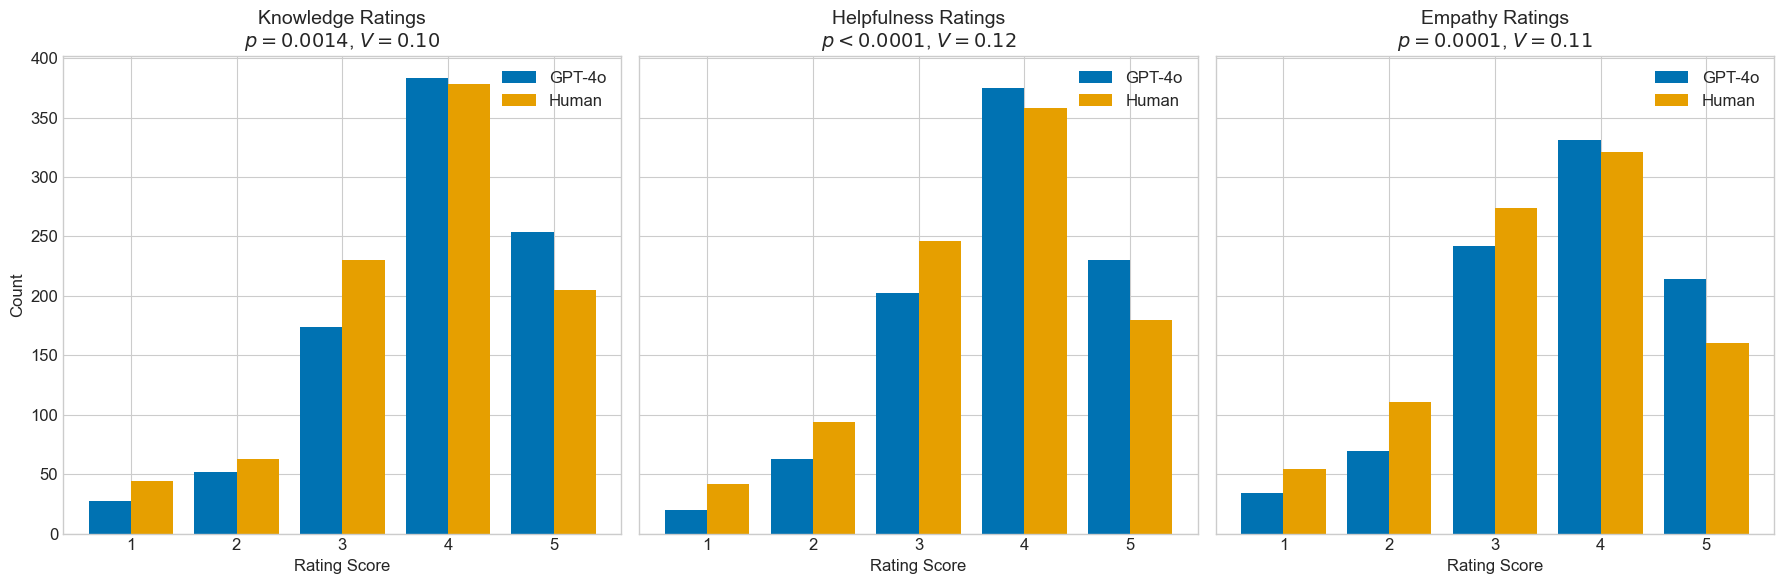

In [21]:
# Define metrics and titles
metrics = ['knowledge', 'helpfulness', 'empathy']
titles = [
    'Knowledge Ratings\n$p = 0.0014$, $V = 0.10$',
    'Helpfulness Ratings\n$p < 0.0001$, $V = 0.12$',
    'Empathy Ratings\n$p = 0.0001$, $V = 0.11$'
]
colors = ['#0072B2', '#E69F00']  # Blue for LLM, Orange for Human

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i]
    # Prepare data for plotting
    data_llm = df[df['source'].str.lower() == 'llm'][metric]
    data_human = df[df['source'].str.lower() == 'human'][metric]
    # Count ratings for each score (1-5)
    llm_counts = data_llm.value_counts().sort_index()
    human_counts = data_human.value_counts().sort_index()
    # Ensure all rating values (1-5) are present
    index = np.arange(1, 6)
    llm_counts = llm_counts.reindex(index, fill_value=0)
    human_counts = human_counts.reindex(index, fill_value=0)
    # Bar width and positions
    bar_width = 0.4
    ax.bar(index - bar_width/2, llm_counts, width=bar_width, color=colors[0], label='GPT-4o')
    ax.bar(index + bar_width/2, human_counts, width=bar_width, color=colors[1], label='Human')
    # Titles and labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Rating Score', fontsize=12)
    if i == 0:
        ax.set_ylabel('Count', fontsize=12)
    ax.set_xticks(index)
    ax.set_xticklabels(index)
    ax.legend()

plt.tight_layout()
fig.savefig('./Figs/figure_2_main_findings.png', dpi=300, bbox_inches='tight')
fig.savefig('./Figs/figure_2_main_findings.pdf', bbox_inches='tight')
plt.show()

In [22]:
# --- Statistical tests and modal ratings ---
for metric in metrics:
    contingency = pd.crosstab(df['source'], df[metric])
    chi2, p, dof, expected = chi2_contingency(contingency)
    n = contingency.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
    # Modal rating
    mode_llm = df[df['source'] == 'llm'][metric].mode()[0]
    mode_human = df[df['source'] == 'human'][metric].mode()[0]
    print(f"{metric.capitalize()}: p = {p:.3g}, Cramer's V = {cramers_v:.2f}, Modal rating: GPT-4o = {mode_llm}, Human = {mode_human}")

Knowledge: p = 0.00144, Cramer's V = 0.10, Modal rating: GPT-4o = 4, Human = 4
Helpfulness: p = 7.12e-05, Cramer's V = 0.12, Modal rating: GPT-4o = 4, Human = 4
Empathy: p = 8.8e-05, Cramer's V = 0.11, Modal rating: GPT-4o = 4, Human = 4


### Preference - metrics combined

**We now define "preference"**

For each row, compare the ratings for GPT-4o and Human for the same question and participant.
But our DataFrame is long format: each row is a single rating for a single answer (either LLM or Human).

To compute preferences, we need to pivot the DataFrame so that for each evaluation (user, question), we have both the LLM and Human ratings side by side.

In [23]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint

# Only keep relevant columns
metrics = ['knowledge', 'helpfulness', 'empathy']
df_pref = df[['user_id', 'question_id', 'source'] + metrics].copy()

# Pivot to wide format: one row per (user_id, question_id), columns for each source
df_wide = df_pref.pivot_table(
    index=['user_id', 'question_id'],
    columns='source',
    values=metrics
)

# Drop rows with any missing values (i.e., where a user didn't rate both sources for a question)
df_wide = df_wide.dropna()

# Sum across metrics for each source
llm_sum = df_wide.xs('llm', axis=1, level=1).sum(axis=1)
human_sum = df_wide.xs('human', axis=1, level=1).sum(axis=1)

# Assign preference
preference = np.where(llm_sum > human_sum, 'llm',
              np.where(human_sum > llm_sum, 'human', 'equal'))

# Create a DataFrame for preference
df_pref_result = pd.DataFrame({
    'llm_sum': llm_sum,
    'human_sum': human_sum,
    'preference': preference
})

# Count preferences
counts = df_pref_result['preference'].value_counts()
n = counts.sum()

# Helper function for CI
def percent_ci(count, n, alpha=0.05):
    lower, upper = proportion_confint(count, n, alpha=alpha, method='normal')
    return 100*count/n, 100*lower, 100*upper

# Calculate percentages and CIs
llm_pct, llm_low, llm_high = percent_ci(counts.get('llm', 0), n)
human_pct, human_low, human_high = percent_ci(counts.get('human', 0), n)
equal_pct, equal_low, equal_high = percent_ci(counts.get('equal', 0), n)

# Print in manuscript style
print(
    f"For the three metrics combined, responses generated by GPT-4o were preferred in\n"
    f"{llm_pct:.1f}% [95% CI: {llm_low:.1f}–{llm_high:.1f}%] of evaluations, \n"
    f"compared to {human_pct:.1f}% [95% CI: {human_low:.1f}–{human_high:.1f}%] for responses from healthcare professionals.\n"
    f"In {equal_pct:.1f}% of cases [95% CI: {equal_low:.1f}–{equal_high:.1f}%], the responses were rated equally."
)

For the three metrics combined, responses generated by GPT-4o were preferred in
46.7% [95% CI: 28.8–64.5%] of evaluations, 
compared to 23.3% [95% CI: 8.2–38.5%] for responses from healthcare professionals.
In 30.0% of cases [95% CI: 13.6–46.4%], the responses were rated equally.


## Chi-square analysis

Code to **support** the chi-square analyses, including:

- The chi-square statistic, p-value, and Cramer's V for each metric
- 95% confidence intervals for Cramer's V (using bootstrap)
- Bonferroni correction for multiple comparisons

In [24]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Ensure source is lowercase for consistency
df['source'] = df['source'].str.lower()

metrics = ['knowledge', 'helpfulness', 'empathy']

def bootstrap_cramers_v(df, metric, n_bootstrap=1000, random_state=42):
    np.random.seed(random_state)
    v_values = []
    for _ in range(n_bootstrap):
        sample = df.sample(frac=1, replace=True)
        contingency = pd.crosstab(sample['source'], sample[metric])
        chi2, _, _, _ = chi2_contingency(contingency)
        n = contingency.sum().sum()
        v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
        v_values.append(v)
    lower = np.percentile(v_values, 2.5)
    upper = np.percentile(v_values, 97.5)
    return lower, upper

alpha = 0.05
bonferroni_alpha = alpha / len(metrics)

for metric in metrics:
    contingency = pd.crosstab(df['source'], df[metric])
    chi2, p, dof, expected = chi2_contingency(contingency)
    n = contingency.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
    ci_low, ci_high = bootstrap_cramers_v(df, metric)
    p_str = f"p = {p:.3g}" if p >= 0.001 else "p < 0.001"
    sig = "significant" if p < bonferroni_alpha else "not significant"
    print(
        f"{metric.capitalize()}: "
        f"$\\chi^2({dof}) = {chi2:.2f}$, {p_str}, V = {cramers_v:.3f} [95% CI: {ci_low:.3f}--{ci_high:.3f}] "
        f"({sig} after Bonferroni correction, $\\alpha = {bonferroni_alpha:.3f}$)"
    )

Knowledge: $\chi^2(4) = 17.66$, p = 0.00144, V = 0.099 [95% CI: 0.061--0.153] (significant after Bonferroni correction, $\alpha = 0.017$)
Helpfulness: $\chi^2(4) = 24.25$, p < 0.001, V = 0.116 [95% CI: 0.077--0.165] (significant after Bonferroni correction, $\alpha = 0.017$)
Empathy: $\chi^2(4) = 23.79$, p < 0.001, V = 0.115 [95% CI: 0.077--0.165] (significant after Bonferroni correction, $\alpha = 0.017$)


**Proportions of ratings:**
- Quantifies the difference in top-category (5) ratings for empathy between GPT-4o and human.
- Quantifies the difference in low-category (1–3) ratings for empathy between groups.
- Repeats both for the diabetes subgroup, confirming the pattern.

In [25]:
# 1. Proportion of empathy ratings = 5 for each group
empathy_5 = df[df['empathy'] == 5].groupby('source').size()
empathy_total = df.groupby('source').size()
prop_5 = 100 * empathy_5 / empathy_total

diff_5 = prop_5['llm'] - prop_5['human']

print(f"Proportion of empathy ratings = 5: GPT-4o: {prop_5['llm']:.2f}%, Human: {prop_5['human']:.2f}%")
print(f"Difference (GPT-4o - Human): {diff_5:.1f}%")

# 2. Proportion of empathy ratings in 1–3 for each group
empathy_low = df[df['empathy'].isin([1,2,3])].groupby('source').size()
prop_low = 100 * empathy_low / empathy_total

print(f"Proportion of empathy ratings 1–3: GPT-4o: {prop_low['llm']:.2f}%, Human: {prop_low['human']:.2f}%")

# 3. Subgroup analysis: participants with diabetes
df_diabetes = df[df['has_diabetes'].str.lower() == 'yes']

empathy_5_diab = df_diabetes[df_diabetes['empathy'] == 5].groupby('source').size()
empathy_total_diab = df_diabetes.groupby('source').size()
prop_5_diab = 100 * empathy_5_diab / empathy_total_diab

empathy_low_diab = df_diabetes[df_diabetes['empathy'].isin([1,2,3])].groupby('source').size()
prop_low_diab = 100 * empathy_low_diab / empathy_total_diab

print(f"[Diabetes subgroup] Proportion of empathy ratings = 5: GPT-4o: {prop_5_diab['llm']:.2f}%, Human: {prop_5_diab['human']:.2f}%")
print(f"[Diabetes subgroup] Proportion of empathy ratings 1–3: GPT-4o: {prop_low_diab['llm']:.2f}%, Human: {prop_low_diab['human']:.2f}%")

Proportion of empathy ratings = 5: GPT-4o: 24.04%, Human: 17.39%
Difference (GPT-4o - Human): 6.7%
Proportion of empathy ratings 1–3: GPT-4o: 38.76%, Human: 47.72%
[Diabetes subgroup] Proportion of empathy ratings = 5: GPT-4o: 23.87%, Human: 17.26%
[Diabetes subgroup] Proportion of empathy ratings 1–3: GPT-4o: 39.47%, Human: 48.34%


**1. Proportion of category 5 for empathy (LLM vs Human)**

In [26]:
# Calculate proportion of empathy ratings that are 5, for each source
empathy_5 = df[df['empathy'] == 5].groupby('source').size()
empathy_total = df.groupby('source').size()
prop_5 = 100 * empathy_5 / empathy_total

# Difference
diff_5 = prop_5['llm'] - prop_5['human']

print(f"Proportion of empathy ratings = 5: GPT-4o: {prop_5['llm']:.1f}%, Human: {prop_5['human']:.1f}%")
print(f"Difference (GPT-4o - Human): {diff_5:.1f}%")

Proportion of empathy ratings = 5: GPT-4o: 24.0%, Human: 17.4%
Difference (GPT-4o - Human): 6.7%


**2. Proportion of lower categories (1–3) for empathy (LLM vs Human)**

In [27]:
# Proportion of empathy ratings in 1, 2, or 3
empathy_low = df[df['empathy'].isin([1,2,3])].groupby('source').size()
prop_low = 100 * empathy_low / empathy_total

print(f"Proportion of empathy ratings 1–3: GPT-4o: {prop_low['llm']:.1f}%, Human: {prop_low['human']:.1f}%")

Proportion of empathy ratings 1–3: GPT-4o: 38.8%, Human: 47.7%


**3. Subgroup analysis: participants with diabetes**

In [28]:
# Restrict to participants with diabetes
df_diabetes = df[df['has_diabetes'].str.lower() == 'yes']

# Proportion of empathy = 5
empathy_5_diab = df_diabetes[df_diabetes['empathy'] == 5].groupby('source').size()
empathy_total_diab = df_diabetes.groupby('source').size()
prop_5_diab = 100 * empathy_5_diab / empathy_total_diab

# Proportion of empathy 1–3
empathy_low_diab = df_diabetes[df_diabetes['empathy'].isin([1,2,3])].groupby('source').size()
prop_low_diab = 100 * empathy_low_diab / empathy_total_diab

print(f"[Diabetes subgroup] Proportion of empathy ratings = 5: GPT-4o: {prop_5_diab['llm']:.1f}%, Human: {prop_5_diab['human']:.1f}%")
print(f"[Diabetes subgroup] Proportion of empathy ratings 1–3: GPT-4o: {prop_low_diab['llm']:.1f}%, Human: {prop_low_diab['human']:.1f}%")

[Diabetes subgroup] Proportion of empathy ratings = 5: GPT-4o: 23.9%, Human: 17.3%
[Diabetes subgroup] Proportion of empathy ratings 1–3: GPT-4o: 39.5%, Human: 48.3%


## Additional findings

### Correlation heatmaps

- Calculate pairwise Pearson's correlations ($r$) for the selected variables, separately for GPT-4o and Human responses.
- Test for statistical significance (with Bonferroni correction).
- Calculate power for each correlation (report only those with power > 0.80).
- Plot annotated heatmaps for each group, showing only significant & sufficiently powered correlations.

The **Bonferroni correction** is used to control the **family-wise error rate** when performing multiple statistical tests. The more tests you run, the higher the chance of getting a "significant" result just by random chance (Type I error).

### Why α = 0.003?

The Bonferroni correction adjusts the significance threshold (α) by dividing your desired overall α (commonly 0.05) by the number of comparisons/tests you are making:

$$
\alpha_{\text{Bonferroni}} = \frac{\alpha_{\text{family-wise}}}{\text{number of tests}}
$$

#### In our case:
- We are testing **all pairwise correlations** among 6 variables.
- The number of unique pairs is:
  $$
  \text{Number of tests} = \frac{6 \times 5}{2} = 15
  $$
- If we want the overall family-wise error rate to be 0.05:
  $$
  \alpha_{\text{Bonferroni}} = \frac{0.05}{15} \approx 0.0033
  $$
- In our code and manuscript, we rounded this to **0.003**.

### **Summary Table**

| Family-wise α | Number of tests | Bonferroni α per test |
|---------------|-----------------|-----------------------|
| 0.05          | 15              | 0.0033                |

### **Why use Bonferroni?**
- It is a **conservative** method to reduce false positives when running multiple tests.
- Ensures that the probability of making **at least one Type I error** across all tests is less than or equal to your chosen family-wise α (e.g., 0.05).
- We use Bonferroni α = 0.003 because we are running 15 pairwise tests and want to keep the overall chance of a false positive at 5%.  
$$
0.05 / 15 \approx 0.003
$$


In [29]:
# If you don't have pingouin, install it:
# !pip install pingouin

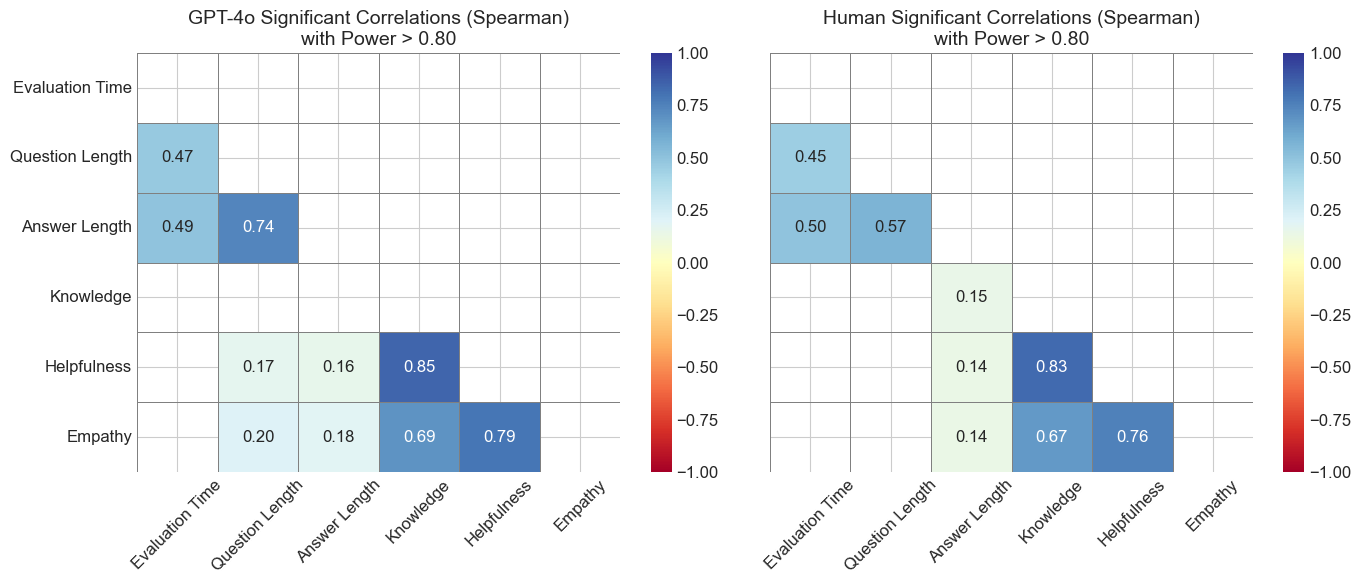

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

method = 'spearman'
method_cap = method.capitalize()

# Select relevant columns and rename for clarity
df_corr = df.copy()
df_corr['Question Length'] = df_corr['question_text'].str.len()
df_corr['Answer Length'] = df_corr['answer_text'].str.len()
df_corr['Evaluation Time'] = df_corr['response_time']
df_corr['Knowledge'] = df_corr['knowledge']
df_corr['Helpfulness'] = df_corr['helpfulness']
df_corr['Empathy'] = df_corr['empathy']

corr_vars = ['Evaluation Time', 'Question Length', 'Answer Length', 'Knowledge', 'Helpfulness', 'Empathy']

def get_sig_corrs(df_sub, alpha=0.003, min_power=0.80):
    # Compute pairwise correlations
    corr_results = []
    for i, var1 in enumerate(corr_vars):
        for j, var2 in enumerate(corr_vars):
            if j <= i:
                continue
            # Drop NA
            data = df_sub[[var1, var2]].dropna()
            if len(data) < 3:
                continue
            res = pg.corr(data[var1], data[var2], method=method)
            r = res['r'].values[0]
            p = res['p-val'].values[0]
            n = len(data)
            # Power analysis
            power = pg.power_corr(r=r, n=n, alpha=alpha)
            # Bonferroni correction: alpha / number of tests
            if p < alpha and power > min_power:
                corr_results.append({'var1': var1, 'var2': var2, 'r': r, 'p': p, 'power': power})
    return corr_results

def build_corr_matrix(corr_results):
    # Build a lower-triangular matrix with only significant, powered correlations
    mat = pd.DataFrame(np.nan, index=corr_vars, columns=corr_vars)
    for res in corr_results:
        mat.loc[res['var2'], res['var1']] = res['r']
    return mat

# Split by source
df_llm = df_corr[df_corr['source'].str.lower() == 'llm']
df_human = df_corr[df_corr['source'].str.lower() == 'human']

# Get significant, powered correlations
llm_corrs = get_sig_corrs(df_llm)
human_corrs = get_sig_corrs(df_human)

# Build matrices
llm_mat = build_corr_matrix(llm_corrs)
human_mat = build_corr_matrix(human_corrs)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, mat, title in zip(
    axes,
    [llm_mat, human_mat],
    [f'GPT-4o Significant Correlations ({method_cap})\nwith Power > 0.80', f'Human Significant Correlations ({method_cap})\nwith Power > 0.80']
):
    sns.heatmap(
        mat, annot=True, fmt=".2f", cmap='RdYlBu', vmin=-1, vmax=1,
        mask=mat.isnull(), cbar=True, ax=ax, linewidths=0.5, linecolor='gray',
        annot_kws={"size": 12}
    )
    ax.set_title(title, fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
fig.savefig(f'./Figs/figure_3_{method_cap}_correlation_analysis.png', dpi=300, bbox_inches='tight')
fig.savefig(f'./Figs/figure_3_{method_cap}_correlation_analysis.pdf', bbox_inches='tight')
plt.show()

#### Long questions and Evaluation time

In the following code, we:

- Calculates empathy improvement for long questions (>35 words) in GPT-4o.
- Compares empathy gain for GPT-4o vs human, with effect size and p-value.
- Reports median, IQR, and mean evaluation times for both groups, with statistical test and effect size.
- Checks for right-skewed distribution (mean > median).

In [31]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

# Convert response_time to seconds if needed
if df['response_time'].max() > 10000:
    df['response_time_sec'] = df['response_time'] / 1000
else:
    df['response_time_sec'] = df['response_time']

# Manual implementation of Cliff's delta
def cliffs_delta(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    n_x = len(x)
    n_y = len(y)
    more = sum(xi > yj for xi in x for yj in y)
    less = sum(xi < yj for xi in x for yj in y)
    delta = (more - less) / (n_x * n_y)
    return delta

# 1. Add question length column
df['question_length'] = df['question_text'].str.split().apply(len)

# 2. Filter for long questions (>35 words)
long_q = df[df['question_length'] > 35]
short_q = df[df['question_length'] <= 35]

# 3. Empathy improvement for GPT-4o (mean, difference, percent)
llm_long = long_q[long_q['source'].str.lower() == 'llm']
llm_short = short_q[short_q['source'].str.lower() == 'llm']

mean_empathy_long = llm_long['empathy'].mean()
mean_empathy_short = llm_short['empathy'].mean()
diff_empathy = mean_empathy_long - mean_empathy_short
percent_improvement = 100 * diff_empathy / mean_empathy_short

print(f"GPT-4o empathy for long questions: {mean_empathy_long:.2f}")
print(f"GPT-4o empathy for short questions: {mean_empathy_short:.2f}")
print(f"Increase: {diff_empathy:.2f} points ({percent_improvement:.1f}%)")

# 4. Compare empathy gain for GPT-4o vs human
human_long = long_q[long_q['source'].str.lower() == 'human']
human_short = short_q[short_q['source'].str.lower() == 'human']

llm_gain = mean_empathy_long - mean_empathy_short
human_gain = human_long['empathy'].mean() - human_short['empathy'].mean()

print(f"Empathy gain (GPT-4o): {llm_gain:.2f}")
print(f"Empathy gain (Human): {human_gain:.2f}")

# Effect size and p-value for difference in empathy for long questions
stat, p = mannwhitneyu(llm_long['empathy'], human_long['empathy'], alternative='two-sided')
cliff = cliffs_delta(llm_long['empathy'], human_long['empathy'])

print(f"Cliff's delta: {cliff:.3f}, p = {p:.3g}")

# 5. Median evaluation time, IQR, mean for both groups

llm_time = llm_long['response_time_sec']
human_time = human_long['response_time_sec']

def describe_time(series):
    median = np.median(series)
    q1 = np.percentile(series, 25)
    q3 = np.percentile(series, 75)
    mean = np.mean(series)
    return median, (q1, q3), mean

llm_median, llm_iqr, llm_mean = describe_time(llm_time)
human_median, human_iqr, human_mean = describe_time(human_time)

print("\nEvaluation time:")
print(f"GPT-4o median eval time: {llm_median:.1f}s (IQR: {llm_iqr[0]:.1f}–{llm_iqr[1]:.1f}s), mean: {llm_mean:.1f}s")
print(f"Human median eval time: {human_median:.1f}s (IQR: {human_iqr[0]:.1f}–{human_iqr[1]:.1f}s), mean: {human_mean:.1f}s")

# Mann-Whitney U for eval time
stat_time, p_time = mannwhitneyu(llm_time, human_time, alternative='two-sided')
cliff_time = cliffs_delta(llm_time, human_time)
print(f"p (eval time): {p_time:.3g}, Cliff's delta: {cliff_time:.3f}")

# 6. Right-skewed? (mean > median)
print(f"GPT-4o mean > median: {llm_mean:.1f} > {llm_median:.1f}")
print(f"Human mean > median: {human_mean:.1f} > {human_median:.1f}")

GPT-4o empathy for long questions: 3.94
GPT-4o empathy for short questions: 3.55
Increase: 0.40 points (11.2%)
Empathy gain (GPT-4o): 0.40
Empathy gain (Human): 0.18
Cliff's delta: 0.213, p = 1.65e-07

Evaluation time:
GPT-4o median eval time: 56.9s (IQR: 36.1–81.9s), mean: 70.9s
Human median eval time: 59.0s (IQR: 40.7–88.5s), mean: 124.3s
p (eval time): 0.0813, Cliff's delta: -0.074
GPT-4o mean > median: 70.9 > 56.9
Human mean > median: 124.3 > 59.0


## Educational level

In [32]:
print(pd.crosstab(df['education_level'], df['source']))

source             human  llm
education_level              
doktorgrad            60   42
grunnskole           227  213
hoyere_1_3           329  304
hoyere_4_5           135  166
hoyere_6_pluss       153  144
prefer_not_to_say     16   21


**Collapse Education Levels**

We map our `education_level` column to three groups:
- 'Primary and Lower Secondary Education'
- 'Higher Education 1-3 Years'
- 'Higher Education ≥4 Years'

In [34]:
# Map actual education levels to three groups
edu_map = {
    'grunnskole': 'Primary/Lower Secondary',
    'hoyere_1_3': 'Higher Ed 1-3 Years',
    'hoyere_4_5': 'Higher Ed ≥4 Years',
    'hoyere_6_pluss': 'Higher Ed ≥4 Years',
    'doktorgrad': 'Higher Ed ≥4 Years',
    'prefer_not_to_say': None  # Exclude from analysis
}

df['edu_group'] = df['education_level'].map(edu_map)
edu_order = ['Primary/Lower Secondary', 'Higher Ed 1-3 Years', 'Higher Ed ≥4 Years']

**Produce the Boxplots**

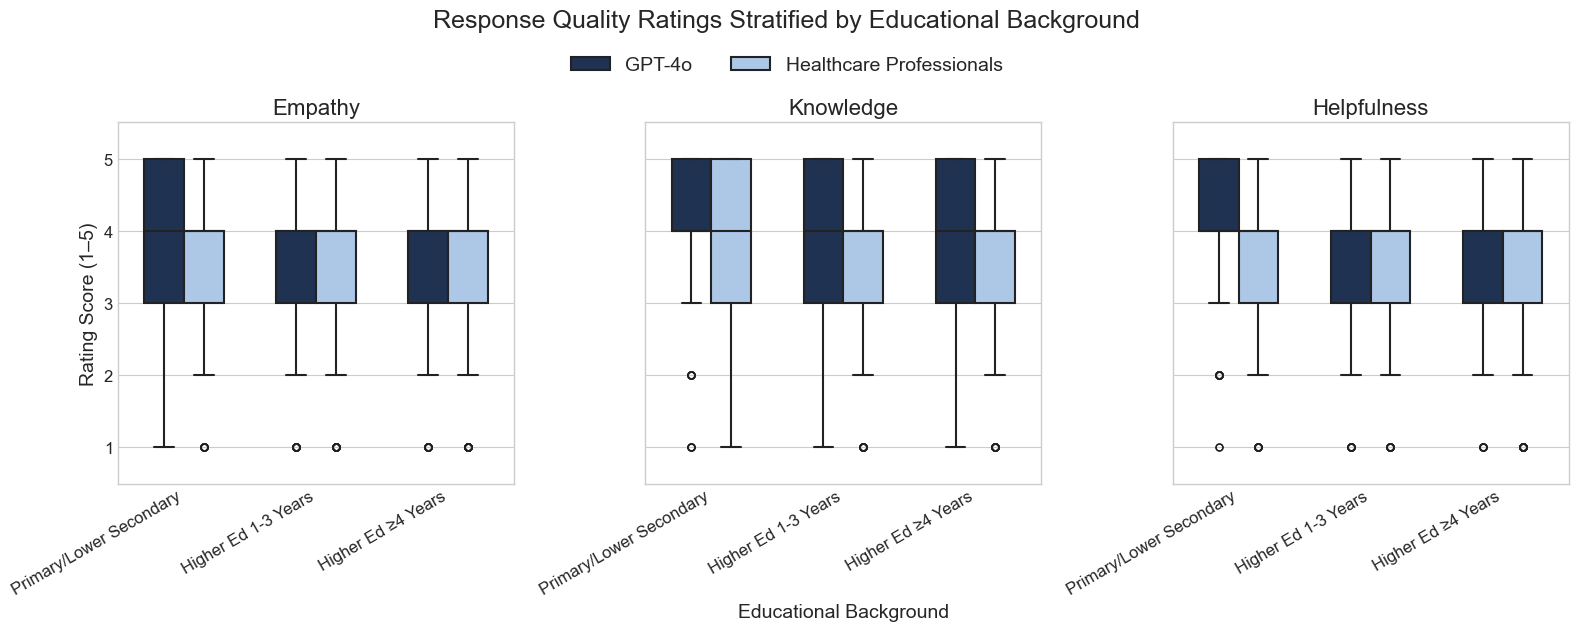

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['empathy', 'knowledge', 'helpfulness']
titles = ['Empathy', 'Knowledge', 'Helpfulness']
palette = ['#183059', '#A3C6F1']  # dark blue, light blue

fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
fig.suptitle('Response Quality Ratings Stratified by Educational Background', fontsize=18, y=1.05)

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i]
    sns.boxplot(
        data=df[df['edu_group'].notna()],
        x='edu_group',
        y=metric,
        hue='source',
        order=edu_order,
        hue_order=['llm', 'human'],
        palette=palette,
        ax=ax,
        width=0.6,
        fliersize=5,
        linewidth=1.5
    )
    ax.set_title(title, fontsize=16)
    if i == 1:
        ax.set_xlabel('Educational Background', fontsize=14)
    else:
        ax.set_xlabel('')
    if i == 0:
        ax.set_ylabel('Rating Score (1–5)', fontsize=14)
    else:
        ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    # Set y-axis from 0.5 to 5.5 with integer ticks
    ax.set_ylim(0.5, 5.5)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels([1, 2, 3, 4, 5])
    
    #if i != 0:
    #    ax.get_legend().remove()
    #else:
    #    ax.legend(title='', labels=['GPT-4o', 'Healthcare Professionals'], loc='upper left')
    
    # Remove individual legends
    ax.legend_.remove()

plt.tight_layout()

# Add a single, centered legend above the subplots
handles, labels = axes[0].get_legend_handles_labels()
labels=['GPT-4o', 'Healthcare Professionals']
fig.legend(
    handles, labels, title='', ncol=2, loc='upper center',
    bbox_to_anchor=(0.5, 1.00), frameon=False, fontsize=14
)

# --- Save the figure in publication quality ---
#fig.savefig('Figs/figure_4_education_level_boxplots.png', dpi=300, bbox_inches='tight')  # PNG, 300 dpi
#fig.savefig('Figs/figure_4_education_level_boxplots.pdf', bbox_inches='tight')          # PDF (vector graphics)
plt.show()

Overlay a stripplot (jitter plot) on top of the split violin plot to show individual observations as small, jittered dots. 

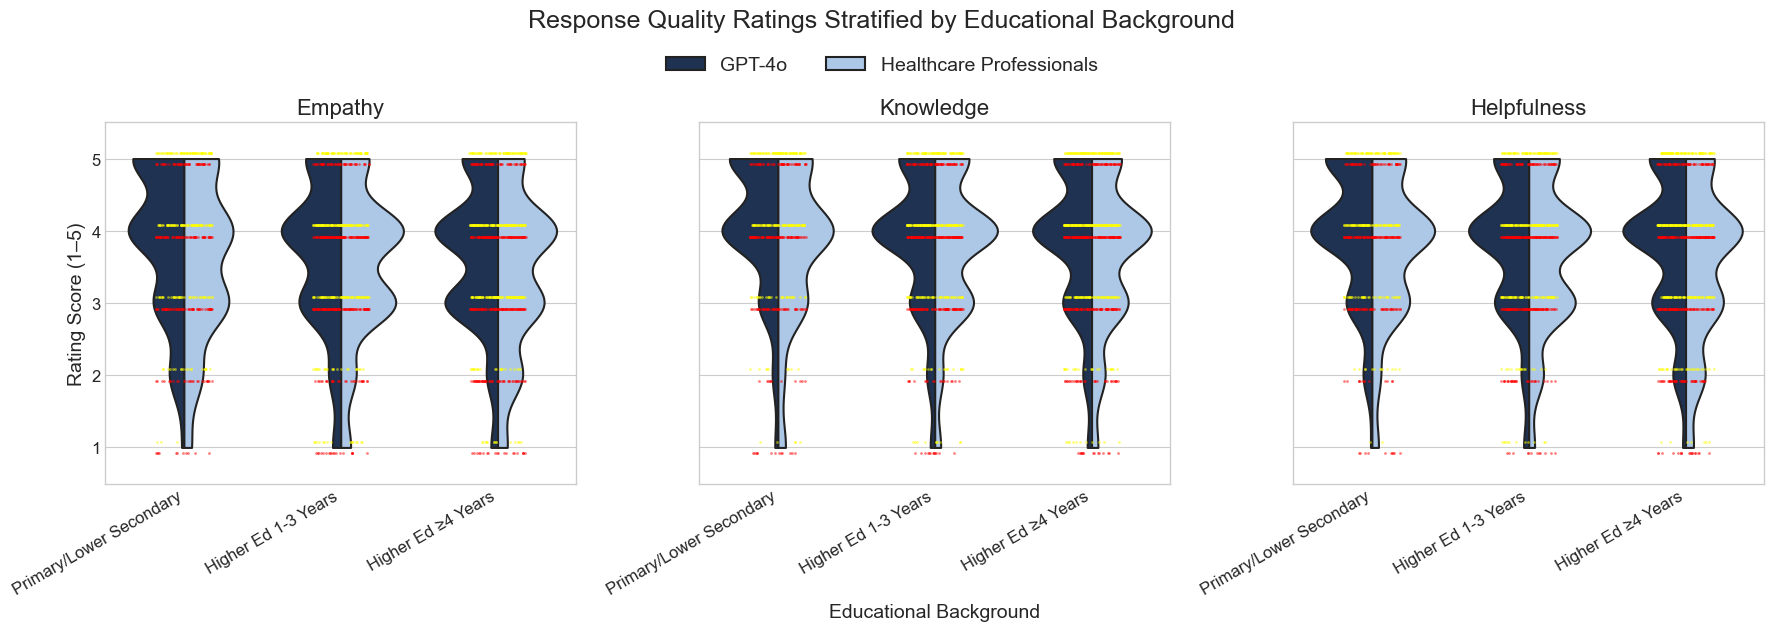

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

metrics = ['empathy', 'knowledge', 'helpfulness']
titles = ['Empathy', 'Knowledge', 'Helpfulness']
edu_order = ['Primary/Lower Secondary', 'Higher Ed 1-3 Years', 'Higher Ed ≥4 Years']
palette = {'llm': '#183059', 'human': '#A3C6F1'}  # dark blue, light blue

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
#fig.suptitle('Split Violin + Horizontally Separated Jittered Observations', fontsize=18, y=1.05)
fig.suptitle('Response Quality Ratings Stratified by Educational Background', fontsize=18, y=1.05)

offset = 0.08  # vertical offset for jitter lines

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i]
    # Split violin plot
    sns.violinplot(
        data=df[df['edu_group'].notna()],
        x='edu_group',
        y=metric,
        hue='source',
        order=edu_order,
        hue_order=['llm', 'human'],
        palette=palette,
        split=True,
        inner=None,
        ax=ax,
        linewidth=1.5,
        cut=0
    )
    # Overlay yellow jittered observations for GPT-4o (slightly above)
    data_llm = df[(df['edu_group'].notna()) & (df['source'] == 'llm')].copy()
    data_llm['y_offset'] = data_llm[metric] + offset
    sns.stripplot(
        data=data_llm,
        x='edu_group',
        y='y_offset',
        order=edu_order,
        color='yellow',
        dodge=True,
        jitter=0.18,
        size=2,
        alpha=0.5,
        ax=ax,
        zorder=1
    )
    # Overlay red jittered observations for Healthcare Professionals (slightly below)
    data_human = df[(df['edu_group'].notna()) & (df['source'] == 'human')].copy()
    data_human['y_offset'] = data_human[metric] - offset
    sns.stripplot(
        data=data_human,
        x='edu_group',
        y='y_offset',
        order=edu_order,
        color='red',
        dodge=True,
        jitter=0.18,
        size=2,
        alpha=0.5,
        ax=ax,
        zorder=1
    )
    # Remove duplicate legends
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    ax.set_title(title, fontsize=16)
    if i == 1:
        ax.set_xlabel('Educational Background', fontsize=14)
    else:
        ax.set_xlabel('')
    if i == 0:
        ax.set_ylabel('Rating Score (1–5)', fontsize=14)
    else:
        ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_ylim(0.5, 5.5)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels([1, 2, 3, 4, 5])

plt.tight_layout()

# Add a single, centered legend above the subplots
handles, labels = axes[0].get_legend_handles_labels()
labels = ['GPT-4o', 'Healthcare Professionals']
fig.legend(
    handles[:2], labels, title='', ncol=2, loc='upper center',
    bbox_to_anchor=(0.5, 1.00), frameon=False, fontsize=14
)

# Save the figure in publication quality
fig.savefig('Figs/figure_4_split_violin_separated_jitter_education.png', dpi=300, bbox_inches='tight')
fig.savefig('Figs/figure_4_split_violin_separated_jitter_education.pdf', bbox_inches='tight')
plt.show()

Distribution of response quality ratings for GPT-4o (dark blue) and healthcare professionals (light blue) across three educational backgrounds and three evaluation dimensions (empathy, knowledge, and helpfulness). Split violin plots display the full distribution of ratings (1--5 Likert scale) for each group, with the left half representing GPT-4o and the right half representing healthcare professionals. Individual ratings are overlaid as jittered dots, with yellow points for GPT-4o and red points for healthcare professionals, horizontally offset for clarity. The plots illustrate that GPT-4o responses received consistently higher ratings across all educational backgrounds, with the largest differences observed in the primary and lower secondary education group.

**Interpretation:**

The figure illustrates the distribution of response quality ratings for GPT-4o and healthcare professionals across three educational backgrounds and three evaluation dimensions. Across all educational groups and metrics, GPT-4o responses consistently received higher ratings than those of healthcare professionals. This difference was most pronounced among participants with primary and lower secondary education, where the distributions for GPT-4o were clearly shifted toward higher scores compared to those for healthcare professionals. The split violin plots reveal that, for all groups, the majority of ratings clustered at the upper end of the scale, but the density of high ratings (scores of 4 and 5) was greater for GPT-4o. The overlaid jittered points further highlight the concentration of high scores for GPT-4o (yellow) and the relatively broader spread of ratings for healthcare professionals (red), particularly in the lower education group. These findings indicate that GPT-4o responses were perceived as higher quality across all educational backgrounds, with the largest advantage observed among participants with lower educational attainment.

**Compute Medians, % Difference, Cliff’s Delta, p-values, and CIs**

In [38]:
import numpy as np
from scipy.stats import mannwhitneyu, norm

# Manual Cliff's delta
def cliffs_delta(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    n_x = len(x)
    n_y = len(y)
    more = sum(xi > yj for xi in x for yj in y)
    less = sum(xi < yj for xi in x for yj in y)
    delta = (more - less) / (n_x * n_y)
    return delta

# 95% CI for Cliff's delta (approximate, normal approx)
def cliffs_delta_ci(x, y, delta, alpha=0.05):
    n_x = len(x)
    n_y = len(y)
    se = np.sqrt((n_x + n_y + 1) / (3 * n_x * n_y))
    z = norm.ppf(1 - alpha/2)
    return delta - z*se, delta + z*se

for edu in edu_order:
    print(f"\n--- {edu} ---")
    for metric in metrics:
        llm = df[(df['edu_group'] == edu) & (df['source'] == 'llm')][metric]
        human = df[(df['edu_group'] == edu) & (df['source'] == 'human')][metric]
        if len(llm) == 0 or len(human) == 0:
            continue
        llm_median = np.median(llm)
        human_median = np.median(human)
        pct_diff_median = 100 * (llm_median - human_median) / human_median
        llm_mean = np.mean(llm)
        human_mean = np.mean(human)
        pct_diff = 100 * (llm_mean - human_mean) / human_mean
        stat, p = mannwhitneyu(llm, human, alternative='two-sided')
        delta = cliffs_delta(llm, human)
        ci_low, ci_high = cliffs_delta_ci(llm, human, delta)
        print(f"{metric.capitalize()}:")
        print(f"  GPT-4o Median = {llm_median:.2f}, Human Median = {human_median:.2f}")
        print(f"  % Difference (median): {pct_diff_median:.1f}%")
        print(f"  GPT-4o Mean = {llm_mean:.2f}, Human Mean = {human_mean:.2f}")
        print(f"  % Difference (mean): {pct_diff:.1f}%")
        print(f"  Cliff's delta = {delta:.3f} [95% CI: {ci_low:.3f}–{ci_high:.3f}], p = {p:.3g}")


--- Primary/Lower Secondary ---
Empathy:
  GPT-4o Median = 4.00, Human Median = 4.00
  % Difference (median): 0.0%
  GPT-4o Mean = 3.91, Human Mean = 3.55
  % Difference (mean): 10.0%
  Cliff's delta = 0.182 [95% CI: 0.074–0.290], p = 0.000596
Knowledge:
  GPT-4o Median = 4.00, Human Median = 4.00
  % Difference (median): 0.0%
  GPT-4o Mean = 4.07, Human Mean = 3.77
  % Difference (mean): 7.9%
  Cliff's delta = 0.162 [95% CI: 0.054–0.270], p = 0.00182
Helpfulness:
  GPT-4o Median = 4.00, Human Median = 4.00
  % Difference (median): 0.0%
  GPT-4o Mean = 4.00, Human Mean = 3.73
  % Difference (mean): 7.2%
  Cliff's delta = 0.147 [95% CI: 0.039–0.255], p = 0.00474

--- Higher Ed 1-3 Years ---
Empathy:
  GPT-4o Median = 4.00, Human Median = 4.00
  % Difference (median): 0.0%
  GPT-4o Mean = 3.65, Human Mean = 3.49
  % Difference (mean): 4.5%
  Cliff's delta = 0.090 [95% CI: 0.000–0.180], p = 0.04
Knowledge:
  GPT-4o Median = 4.00, Human Median = 4.00
  % Difference (median): 0.0%
  GPT-4o

# Appendix A.2

Python code to make four bar plots showing the demographic characteristics of our study participants.  

We distinguish between:
- Healthcare Professionals with Diabetes
- Healthcare Professionals without Diabetes
- Patients with Diabetes (not healthcare professionals)
- General (neither healthcare professional nor diabetes)

In [39]:
# 1. Define the Classification Function
def classify(row):
    if row['is_healthcare_personnel']:
        if row['has_diabetes'].lower() == 'yes':
            return 'Healthcare Prof. w/ Diabetes'
        else:
            return 'Healthcare Prof. w/o Diabetes'
    elif row['has_diabetes'].lower() == 'yes':
        return 'Patient w/ Diabetes'
    else:
        return 'General'

In [40]:
# 2. Apply the Classification and Prepare Counts
df['participant_class'] = df.apply(classify, axis=1)
# Only count unique participants
class_counts = df.drop_duplicates('user_id')['participant_class'].value_counts()
class_labels = [f"{k}\n(n={v}, {v/class_counts.sum()*100:.1f}%)" for k, v in class_counts.items()]

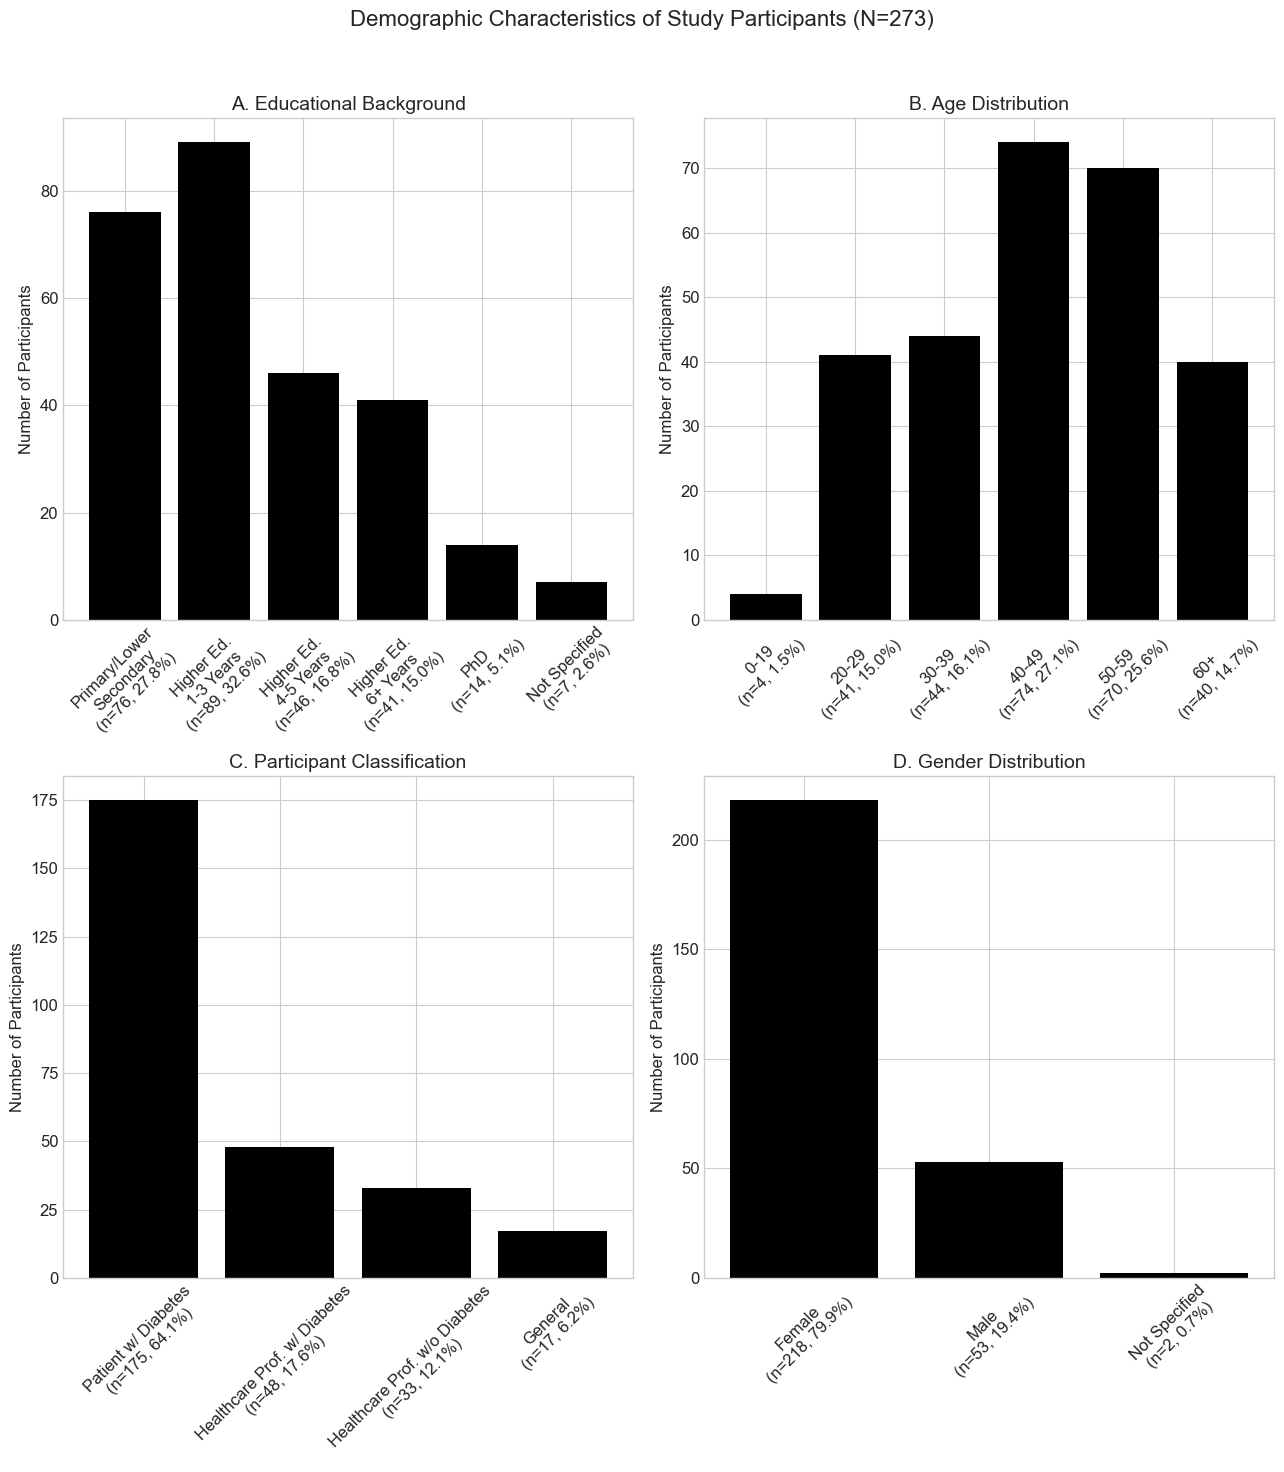

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

# 1. Educational Background
# Get unique participants for education level
edu_counts = df.drop_duplicates('user_id')['education_level'].value_counts()
edu_perc = 100 * edu_counts / edu_counts.sum()

# Define the order you want for the x-axis
edu_order = [
    'grunnskole', 'hoyere_1_3', 'hoyere_4_5', 'hoyere_6_pluss', 'doktorgrad', 'prefer_not_to_say'
]
edu_names = {
    'grunnskole': 'Primary/Lower\nSecondary',
    'hoyere_1_3': 'Higher Ed.\n1-3 Years',
    'hoyere_4_5': 'Higher Ed.\n4-5 Years',
    'hoyere_6_pluss': 'Higher Ed.\n6+ Years',
    'doktorgrad': 'PhD',
    'prefer_not_to_say': 'Not Specified'
}

edu_labels = [
    f"{edu_names[k]}\n(n={edu_counts[k]}, {edu_perc[k]:.1f}%)" if k in edu_counts else edu_names[k]
    for k in edu_order
]

# 2. Age Distribution
age_counts = df.drop_duplicates('user_id')['age_group'].value_counts().sort_index()
age_labels = [f"{k}\n(n={v}, {v/age_counts.sum()*100:.1f}%)" for k, v in age_counts.items()]

# 3. Participant Classification
def classify(row):
    if row['is_healthcare_personnel']:
        if row['has_diabetes'].lower() == 'yes':
            return 'Healthcare Prof. w/ Diabetes'
        else:
            return 'Healthcare Prof. w/o Diabetes'
    elif row['has_diabetes'].lower() == 'yes':
        return 'Patient w/ Diabetes'
    else:
        return 'General'

df['participant_class'] = df.apply(classify, axis=1)
class_counts = df.drop_duplicates('user_id')['participant_class'].value_counts()
class_labels = [f"{k}\n(n={v}, {v/class_counts.sum()*100:.1f}%)" for k, v in class_counts.items()]

# 4. Gender Distribution
# Gender mapping
gender_map = {
    'female': 'Female',
    'male': 'Male',
    'prefer_not_to_say': 'Not Specified'
}

# Get unique participants for gender
gender_counts = df.drop_duplicates('user_id')['gender'].value_counts()
gender_perc = 100 * gender_counts / gender_counts.sum()

# Define the order you want for the x-axis
gender_order = ['female', 'male', 'prefer_not_to_say']

# Build the labels
gender_labels = [
    f"{gender_map[k]}\n(n={gender_counts[k]}, {gender_perc[k]:.1f}%)" if k in gender_counts else gender_map[k]
    for k in gender_order
]



# Plotting
fig, axes = plt.subplots(2, 2, figsize=(13, 15))
fig.suptitle('Demographic Characteristics of Study Participants (N={})'.format(df["user_id"].nunique()), fontsize=16, y=0.98)

# Panel A: Educational Background
axes[0,0].bar(range(len(edu_order)), [edu_counts.get(k, 0) for k in edu_order], color='black') #'#183059')
axes[0,0].set_xticks(range(len(edu_order)))
axes[0,0].set_xticklabels(edu_labels, rotation=45, ha='center', fontsize=12)
axes[0,0].set_ylabel('Number of Participants')
axes[0,0].set_title('A. Educational Background')

# B. Age Distribution
axes[0,1].bar(range(len(age_counts)), age_counts, color='black') #'#A3C6F1')
axes[0,1].set_xticks(range(len(age_counts)))
axes[0,1].set_xticklabels(age_labels, rotation=45, ha='center', fontsize=12)
axes[0,1].set_ylabel('Number of Participants')
axes[0,1].set_title('B. Age Distribution')

# C. Participant Classification (with new categories)
axes[1,0].bar(range(len(class_counts)), class_counts, color='black') #'#183059')
axes[1,0].set_xticks(range(len(class_counts)))
axes[1,0].set_xticklabels(class_labels, rotation=45, ha='center', fontsize=12)
axes[1,0].set_ylabel('Number of Participants')
axes[1,0].set_title('C. Participant Classification')

# Panel D: Gender Distribution
axes[1,1].bar(range(len(gender_order)), [gender_counts.get(k, 0) for k in gender_order], color='black') #'#183059')
axes[1,1].set_xticks(range(len(gender_order)))
axes[1,1].set_xticklabels(gender_labels, rotation=45, ha='center', fontsize=12)
axes[1,1].set_ylabel('Number of Participants')
axes[1,1].set_title('D. Gender Distribution')

plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.savefig('Figs/figure_A2_demographics.png', dpi=300, bbox_inches='tight')
fig.savefig('Figs/figure_A2_demographics.pdf', bbox_inches='tight')
plt.show()